In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from numpy.linalg import eigh



2. Kernel PCA:
• Выберите произвольный набор линейно-неразделимых данных для задачи
классификации;

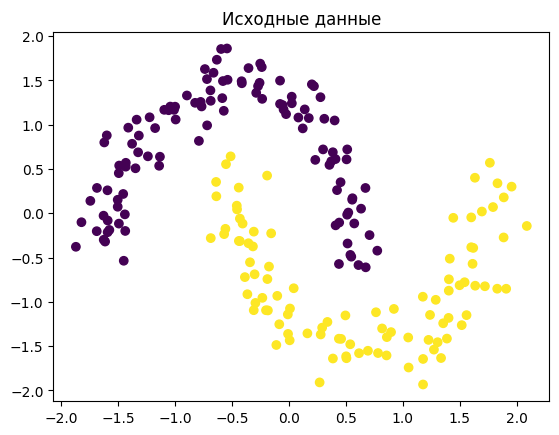

In [34]:
# Создаем линейно-неразделимый набор данных
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

# Разделяем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Визуализация исходных данных
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.title("Исходные данные")
plt.show()


• Реализуйте методы вычисления матрицы для различных ядер (например, на основе полиномиального, радиальной базисной функции, сигмоидального ядер) и её последующего спектрального разложения;

In [35]:
# Полиномиальное ядро
def polynomial_kernel(X, degree=3, coef0=1):
    return (X @ X.T + coef0) ** degree

# RBF (радиальная базисная функция) ядро
def rbf_kernel(X, gamma=0.5):
    sq_dists = -2 * np.dot(X, X.T) + np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(X**2, axis=1)[np.newaxis, :]
    return np.exp(-gamma * sq_dists)

# Сигмоидальное ядро
def sigmoid_kernel(X, coef0=1, gamma=0.5):
    return np.tanh(gamma * X @ X.T + coef0)

def kernel_pca(X, kernel_func, n_components=2, **kwargs):
    # Вычисляем матрицу ядра
    K = kernel_func(X, **kwargs)

    # Центрируем матрицу ядра
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    # Спектральное разложение матрицы ядра
    eigenvalues, eigenvectors = eigh(K_centered)

    # Отбираем компоненты, соответствующие наибольшим собственным значениям
    eigenvectors = eigenvectors[:, -n_components:]
    eigenvalues = eigenvalues[-n_components:]

    # Преобразованные данные
    X_pc = eigenvectors * np.sqrt(eigenvalues)
    return X_pc


• Проведите сравнительный анализ применения PCA и Kernel PCA к данным, сравните проекции на первые главные компоненты при использовании разных ядер, проверьте линейную разделимость. Проверьте, преобразованы ли данные путём к линейно-разделимой форме.

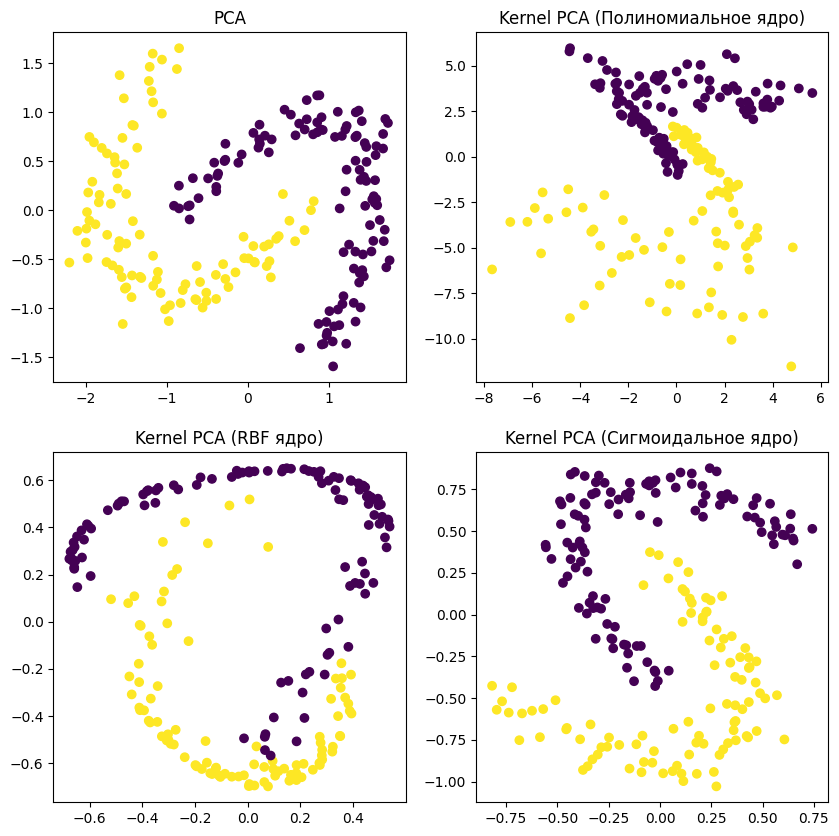

In [36]:
# Применяем Kernel PCA с полиномиальным ядром
X_kpca_poly = kernel_pca(X_train, polynomial_kernel, degree=3)

# Применяем Kernel PCA с RBF ядром
X_kpca_rbf = kernel_pca(X_train, rbf_kernel, gamma=0.5)

# Применяем Kernel PCA с сигмоидальным ядром
X_kpca_sigmoid = kernel_pca(X_train, sigmoid_kernel, gamma=0.5)

# Обычный PCA для сравнения
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Визуализация результатов PCA и Kernel PCA
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
axs[0, 0].set_title("PCA")

axs[0, 1].scatter(X_kpca_poly[:, 0], X_kpca_poly[:, 1], c=y_train, cmap='viridis')
axs[0, 1].set_title("Kernel PCA (Полиномиальное ядро)")

axs[1, 0].scatter(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], c=y_train, cmap='viridis')
axs[1, 0].set_title("Kernel PCA (RBF ядро)")

axs[1, 1].scatter(X_kpca_sigmoid[:, 0], X_kpca_sigmoid[:, 1], c=y_train, cmap='viridis')
axs[1, 1].set_title("Kernel PCA (Сигмоидальное ядро)")

plt.show()

• Оцените изменение значений метрик качества классификации на исходных данных и на преобразованных.

In [37]:
# Обучение SVM на исходных данных
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"Точность на исходных данных: {accuracy_original:.4f}")

# Обучение SVM после обычного PCA
svm.fit(X_pca, y_train[:len(X_pca)])  # y_train[:len(X_pca)] для соответствия размерностей
y_pred_pca = svm.predict(pca.transform(X_test))
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Точность после PCA: {accuracy_pca:.4f}")

# Обучение SVM после Kernel PCA (RBF ядро)
svm.fit(X_kpca_rbf, y_train)
X_test_kpca_rbf = kernel_pca(X_test, rbf_kernel, gamma=0.5)
y_pred_kpca_rbf = svm.predict(X_test_kpca_rbf)
accuracy_kpca_rbf = accuracy_score(y_test, y_pred_kpca_rbf)
print(f"Точность после Kernel PCA (RBF ядро): {accuracy_kpca_rbf:.4f}")

# Обучение модели SVM на данных после Kernel PCA с полиномиальным ядром
svm.fit(X_kpca_poly, y_train)
X_test_kpca_poly = kernel_pca(X_test, polynomial_kernel, degree=3)  # Исправлено
y_pred_kpca_poly = svm.predict(X_test_kpca_poly)
accuracy_kpca_poly = accuracy_score(y_test, y_pred_kpca_poly)
print(f"Точность классификации после Kernel PCA (полиномиальное ядро): {accuracy_kpca_poly:.4f}")

# Обучение модели SVM на данных после Kernel PCA с сигмоидальным ядром
svm.fit(X_kpca_sigmoid, y_train)
X_test_kpca_sigmoid = kernel_pca(X_test, sigmoid_kernel, gamma=0.5)  # Исправлено
y_pred_kpca_sigmoid = svm.predict(X_test_kpca_sigmoid)
accuracy_kpca_sigmoid = accuracy_score(y_test, y_pred_kpca_sigmoid)
print(f"Точность классификации после Kernel PCA (сигмоидальное ядро): {accuracy_kpca_sigmoid:.4f}")


Точность на исходных данных: 0.9000
Точность после PCA: 0.9000
Точность после Kernel PCA (RBF ядро): 0.9222
Точность классификации после Kernel PCA (полиномиальное ядро): 0.8556
Точность классификации после Kernel PCA (сигмоидальное ядро): 0.8889
